##Library Import

In [114]:

import numpy as np
import math
import random
from typing import List, Tuple, Dict, Any, Optional
import time


##Class Definitions

In [115]:
class Action:
    """
    Action class representing an action in the reinforcement learning environment
    """
    def __init__(self):
        self.m: int = 0  # number of states
        self.s0: int = 0  # initial state
        self.r: List[float] = []  # reward vector
        self.t: List[List[float]] = []  # transition matrix
        self.record: List[int] = []  # record of some counts
        self.transition_record: List[List[List[float]]] = []  # 3D transition records
        self.power_record: List[List[List[float]]] = []  # 3D power records

class Observation:
    """
    Observation class representing the current state of the environment
    """
    def __init__(self):
        self.n: int = 0  # number of arms/actions
        self.s: List[int] = []  # current states
        self.t: List[int] = []  # current times
        self.real_distribution: List[List[float]] = []  # real probability distributions
        self.real_distribution_pseudo: List[List[float]] = []  # pseudo probability distributions

class State:
    """
    State class representing a state in the MDP
    """
    def __init__(self):
        self.n: int = 0  # number of arms/actions
        self.m: int = 0  # number of states
        self.states: List[int] = []  # state indices
        self.times: List[int] = []  # time indices
        self.transitions: List[List[float]] = []  # transition probabilities
        self.rewards: List[float] = []  # reward values
        self.Next_stat: List[List[Optional['State']]] = []  # pointers to next states
        self.avai: bool = False  # availability flag
        self.V_value: float = 0.0  # value function
        self.action: int = 0  # selected action

class Direct_Trans_Observation:
    """
    Direct transition observation class for recording state transitions
    """
    def __init__(self):
        self.action: int = 0  # action taken
        self.state: int = 0  # current state
        self.transit_to: List[int] = []  # states transitioned to
        self.num: int = 0  # number of transitions

class Prior_Distribution:
    """
    Prior distribution class for Bayesian inference
    """
    def __init__(self):
        self.n: int = 0  # number of arms/actions
        self.m: int = 0  # number of states
        self.size: int = 0  # size parameter
        self.distribution: List[List[List[float]]] = []  # 3D distribution array


#for the number of cascading bandits we need

##Helper Functions

In [116]:
def uniform_random():
    """Generate uniform random number between 0 and 1"""
    max_val = 16384
    r = (random.randint(0, max_val - 1) + 0.0) / max_val
    return r

def bernoulli(p):
    """Generate Bernoulli random variable with probability p"""
    if uniform_random() < p:
        return 1
    return 0

def random_state(p):
    """Sample random state based on probability distribution p"""
    r = uniform_random()
    q = 0
    for i in range(len(p)):
        q += p[i]
        if q > r:
            return i
    return len(p) - 1

def print_vector(v):
    """Print vector elements"""
    for val in v:
        print(val)
    print()

##Helper Function-II

In [117]:
def init_actions(filename):
    """Initialize actions from file"""
    with open(filename, 'r') as input_file:
        N = int(input_file.readline().strip()) #Number of arms
        M = int(input_file.readline().strip()) #Number of states

        #Initial states
        #
        S = []
        s_line = input_file.readline().strip().split()
        for i in range(N):
            S.append(int(s_line[i]))

        R = []
        for i in range(N):
            Ri = []
            line = input_file.readline().strip().split()
            for j in range(M):
                Ri.append(float(line[j]))
            R.append(Ri)

        T = []
        for i in range(N):
            Ti = []
            for j in range(M):
                Tij = []
                line = input_file.readline().strip().split()
                for k in range(M):
                    Tij.append(float(line[k]))
                Ti.append(Tij)
            T.append(Ti)

    return create_actions(N, M, S, R, T)

def create_actions(N, M, S, R, T):
    """Create actions from parameters"""
    actions = []
    for i in range(N):
        action = Action()
        action.m = M
        action.r = R[i]
        action.s0 = S[i]
        action.t = T[i]
        action.power_record = [T[i]]
        actions.append(action)
    return actions

def init_observation(actions):
    """Initialize observation based on actions"""
    if not actions:
        raise ValueError("Actions list is empty")
    
    ob = Observation()
    ob.n = len(actions)
    ob.s = [0] * ob.n  # Start all arms in state 0
    ob.t = [1] * ob.n  # All arms start at time 1
    
    # Initialize real distributions
    ob.real_distribution = []
    for i in range(ob.n):
        # Start with initial distribution (all probability on current state)
        start_dist = [0.0] * actions[i].m
        start_dist[ob.s[i]] = 1.0
        ob.real_distribution.append(start_dist)
    
    return ob

def update_observation(ob, arm, action):
    """Update observation (original version)"""
    ob2 = Observation()
    ob2.n = ob.n
    states = []
    times = []

    for i in range(ob.n):
        if i != arm:
            states.append(ob.s[i])
            times.append(ob.t[i] + 1)
        else:
            states.append(next_state(ob.s[i], ob.t[i], action))
            times.append(1)

    ob.s = states
    ob.t = times
    return ob

def next_state(s, t, action):
    """Get next state"""
    if t == 1:
        return random_state(action.t[s])

    print("???")
    n = len(action.record)
    i = 0
    for i in range(n):
        if action.record[i] == t:
            break

    if i < n:
        return random_state(action.transition_record[i][s])

    transition = matrix_power(action.t, t, action)
    action.record.append(t)
    action.transition_record.append(transition)
    return random_state(transition[s])

def matrix_power(M, t, action):
    """Compute matrix power using binary exponentiation"""
    n = len(action.power_record)
    result = identical_matrix(len(M))
    u = t
    v = 0
    index = 0

    while u > 0:
        v = u % 2
        u = u // 2
        if v == 1:
            result = matrix_multiply(result, action.power_record[index])
        index += 1
        if index >= n:
            action.power_record.append(matrix_multiply(action.power_record[-1], action.power_record[-1]))

    return result

def matrix_multiply(M, N):
    """Multiply two matrices"""
    result = []
    for i in range(len(M)):
        ri = [0.0] * len(M)
        for j in range(len(M)):
            for k in range(len(M)):
                ri[j] += M[i][k] * N[k][j]
        result.append(ri)
    return result

def identical_matrix(n):
    """Create identity matrix"""
    result = []
    for i in range(n):
        row = [0.0] * n
        row[i] = 1.0
        result.append(row)
    return result

def update2(ob, arm, actions):
    """Update observation (version 2)"""
    ob2 = Observation()
    ob2.n = ob.n
    states = []
    real_distribution = []
    times = []

    for i in range(ob.n):
        if i != arm:
            states.append(ob.s[i])
            times.append(ob.t[i] + 1)
            distribution_i = next_distribution(ob.real_distribution[i], actions[i].t)
        else:
            state = random_state(ob.real_distribution[i])
            states.append(state)
            times.append(1)
            distribution_i = actions[i].t[state]
        real_distribution.append(distribution_i)

    ob.s = states
    ob.t = times
    ob.real_distribution = real_distribution
    return ob

def next_distribution(distribution, transition):
    """Compute next distribution"""
    d = []
    n = len(distribution)
    for i in range(n):
        sum_val = 0
        for j in range(n):
            sum_val += distribution[j] * transition[j][i]
        d.append(sum_val)
    return d


##Game and Policy Definitions - Whittle

In [170]:

import random
import math

def game_default(actions, T):
    """Run game with default policy"""
    ob = init_observation(actions)
    t = 0
    reward = 0

    while t < T:
        arm = policy_default(ob)
        ob = update2(ob, arm, actions)
        reward += bernoulli(actions[arm].r[ob.s[arm]])
        t += 1

    return reward

def policy_default(ob):
    """Default random policy"""
    return random.randint(0, ob.n - 1)

def game_whittle(actions, T, k=1):
    """Run game with Whittle policy - supports k-armed selection"""
    ob = init_observation(actions)
    t = 0
    reward = 0

    while t < T:
        arms = policy_whittle(ob, actions, k)
        # For single arm selection (backward compatibility)
        if k == 1:
            arm = arms[0] if isinstance(arms, list) else arms
            ob = update2(ob, arm, actions)
            reward += bernoulli(actions[arm].r[ob.s[arm]])
        else:
            # For k-armed selection in cascading model
            for arm in arms:
                ob = update2(ob, arm, actions)
                reward += bernoulli(actions[arm].r[ob.s[arm]])
        t += 1
        if t % 200 == 0:
            print(f"The game is in timestep {t}")

    return reward

def policy_whittle(ob, actions, k=1):
    """Whittle index policy - returns top k arms"""
    # print(f"ob.n: {ob.n}")
    # print(f"len(actions): {len(actions)}")
    # print(f"len(ob.real_distribution): {len(ob.real_distribution)}")

    index = []
    for i in range(ob.n):
        #print(f"Processing arm {i}")
        index.append(whittle_index(ob.real_distribution[i], actions[i]))
        index = []
        for i in range(ob.n):
            index.append(whittle_index(ob.real_distribution[i], actions[i]))
        
        # Sort arms by their Whittle indices in descending order
        sorted_arms = sorted(range(ob.n), key=lambda i: index[i], reverse=True)
        
        if k == 1:
            return sorted_arms[0]
        else:
            return sorted_arms[:k]

def whittle_index(distribution, action):
    """Compute Whittle index"""
    if action.t[1][1] >= action.t[0][1]:
        omega = distribution[1]
        omega0 = action.t[0][1] / (action.t[0][1] + action.t[1][0])

        if omega <= action.t[0][1]:
            return omega * (action.r[1] - action.r[0]) + action.r[0]
        elif omega >= action.t[1][1]:
            return omega * (action.r[1] - action.r[0]) + action.r[0]
        elif omega >= omega0:
            return omega / (1 - action.t[1][1] + omega) * (action.r[1] - action.r[0]) + action.r[0]
        else:
            L = l_function(action.t[0][1], omega, action)
            p1 = t_function(1, omega, action)
            p2 = t_function(L, action.t[0][1], action)
            return ((omega - p1) * (L + 1) + p2) / (1 - action.t[1][1] + (omega - p1) * L + p2) * (action.r[1] - action.r[0]) + action.r[0]
    else:
        omega = distribution[1]
        omega0 = action.t[0][1] / (action.t[0][1] + action.t[1][0])
        t_val = t_function(1, action.t[1][1], action)
        p1 = t_function(1, omega, action)

        if omega <= action.t[1][1]:
            return omega * (action.r[1] - action.r[0]) + action.r[0]
        elif omega >= action.t[0][1]:
            return omega * (action.r[1] - action.r[0]) + action.r[0]
        elif omega < omega0:
            return (omega + action.t[0][1] - p1) / (1 + action.t[0][1] - t_val + p1 - omega) * (action.r[1] - action.r[0]) + action.r[0]
        elif omega < t_val:
            return action.t[0][1] / (1 + action.t[0][1] - t_val) * (action.r[1] - action.r[0]) + action.r[0]
        else:
            return action.t[0][1] / (1 + action.t[0][1] - omega) * (action.r[1] - action.r[0]) + action.r[0]

def l_function(omega1, omega2, action):
    """L function for Whittle index calculation"""
    p1 = action.t[1][1] - action.t[0][1]
    if p1 <= 0:
        return 1
    
    # Check denominator for division by zero
    denominator = action.t[0][1] - omega1 * (1 - p1)
    if abs(denominator) < 1e-10:  # Very small number, essentially zero
        return 1
    
    # Calculate the fraction
    numerator = action.t[0][1] - omega2 * (1 - p1)
    fraction = abs(numerator / denominator)
    
    # Check if fraction is too small for log
    if fraction <= 1e-10:  # Very small number, essentially zero
        return 1
    
    p2 = math.log(fraction)
    p3 = math.log(p1)
    return max(1, int(p2 / p3) + 1)

def t_function(t, omega, action):
    """T function for matrix transition"""
    transition = matrix_power(action.t, t, action)
    return (1 - omega) * transition[0][1] + omega * transition[1][1]

def game_reucb(actions, T, k=1):
    """Run game with ReUCB algorithm - supports k-armed selection"""
    ob = init_observation(actions)
    t = 0
    reward = 0
    observations = init_direct_trans_observation(actions)
    m_t = int(pow(T, 2.0/3)) + 1
    start = 0
    n = len(actions)
    m = actions[0].m

    # Exploration phase: collect m_t samples for each arm-state pair
    while start < n and t < T:
        arm = start
        state_samples = [0] * m  # Track samples per state for current arm
        
        while min(state_samples) < m_t and t < T:
            start_state = ob.s[start]
            ob = update2(ob, arm, actions)
            reward += bernoulli(actions[arm].r[ob.s[arm]])
            end_state = ob.s[start]
            
            observations[start][start_state].num += 1
            observations[start][start_state].transit_to[end_state] += 1
            state_samples[start_state] += 1
            
            t += 1
        start += 1

    # Compute confidence radius
    rad = math.sqrt(math.log(T) / (2 * m_t))
    actions_2 = estimate_ucb(observations, actions, rad)

    # Initialize pseudo distributions
    pseudo_distributions = []
    for i in range(ob.n):
        start_dist = [0.0] * actions[0].m
        start_dist[ob.s[i]] = 1.0
        pseudo_distributions.append(next_distribution(start_dist, matrix_power(actions_2[i].t, ob.t[i], actions_2[i])))
    ob.real_distribution_pseudo = pseudo_distributions

    # Exploitation phase with k-armed selection
    while t < T:
        arms = policy_whittle_pseudo(ob, actions_2, k)
        if k == 1:
            arm = arms[0] if isinstance(arms, list) else arms
            ob = update3(ob, arm, actions, actions_2)
            reward += bernoulli(actions[arm].r[ob.s[arm]])
        else:
            # For cascading model: try arms in order until success or all tried
            for arm in arms:
                ob = update3(ob, arm, actions, actions_2)
                arm_reward = bernoulli(actions[arm].r[ob.s[arm]])
                reward += arm_reward
                if arm_reward == 1:  # Success - stop cascading
                    break
        t += 1

    return reward

def omega_star_function(m, action, start, end):
    """Binary search for omega star"""
    mid = (end + start) / 2
    if end - start < 0.00001:
        return mid

    d = [1 - mid, mid]
    v = whittle_index(d, action)

    if v < m:
        return omega_star_function(m, action, mid, end)
    else:
        return omega_star_function(m, action, start, mid)

def j_function(m, action):
    """J function calculation"""
    omega_0 = action.t[0][1] / (action.t[0][1] + action.t[1][0])
    omega_star = omega_star_function(m, action, 0.0, 1.0)

    if omega_star < action.t[0][1]:
        return omega_0 * (action.r[1] - action.r[0]) + action.r[0]
    elif omega_star >= omega_0:
        return m
    else:
        L = l_function(action.t[0][1], omega_star, action)
        p1 = t_function(L, action.t[0][1], action)
        return ((1 - action.t[1][1]) * m * L + p1 * action.r[1] + (1 - action.t[1][1]) * action.r[0]) / ((1 - action.t[1][1]) * (L + 1) + p1)

def init_direct_trans_observation(actions):
    """Initialize direct transition observations"""
    observations = []
    n = len(actions)
    m = actions[0].m

    for i in range(n):
        ob_i = []
        for j in range(m):
            ob_ij = Direct_Trans_Observation()
            ob_ij.action = i
            ob_ij.state = j
            ob_ij.transit_to = [0] * m
            ob_ij.num = 0
            ob_i.append(ob_ij)
        observations.append(ob_i)

    return observations

def estimate_ucb(observations, actions, rad):
    """Estimate actions using UCB"""
    N = len(observations)
    M = len(observations[0])

    S = [0] * N

    R = []
    for i in range(N):
        Ri = []
        for j in range(M):
            Ri.append(actions[i].r[j])
        R.append(Ri)

    T = []
    for i in range(N):
        Ti = []
        for j in range(M):
            Tij = []
            for k in range(M):
                if observations[i][j].num > 0:
                    estimate = (observations[i][j].transit_to[k] + 0.0) / observations[i][j].num
                    if k == 0:
                        Tij.append(max(0, estimate - rad))
                    elif k == M - 1:  # Fixed: was k == M
                        Tij.append(min(1, estimate + rad))
                    else:
                        Tij.append(estimate)
                else:
                    # Default transition probabilities when no observations
                    Tij.append(actions[i].t[j][k])
            Ti.append(Tij)
        T.append(Ti)

    return create_actions(N, M, S, R, T)

def policy_whittle_pseudo(ob, actions, k=1):
    """Policy using pseudo distributions - supports k-armed selection"""
    index = []
    for i in range(ob.n):
        index.append(whittle_index(ob.real_distribution_pseudo[i], actions[i]))

    # Sort arms by their Whittle indices in descending order
    sorted_arms = sorted(range(ob.n), key=lambda i: index[i], reverse=True)
    
    if k == 1:
        return sorted_arms[0]
    else:
        return sorted_arms[:k]

def policy_whittle_pseudo_score(ob, actions_2, arm_index):
    """
    Helper function to calculate Whittle index score for a specific arm.
    """
    if hasattr(ob, 'real_distribution_pseudo') and ob.real_distribution_pseudo:
        # Calculate Whittle index for the specific arm
        whittle_score = whittle_index(ob.real_distribution_pseudo[arm_index], actions_2[arm_index])
        return whittle_score
    else:
        # Fallback: use expected reward as score
        if hasattr(actions_2[arm_index], 'r') and len(actions_2[arm_index].r) > 1:
            return actions_2[arm_index].r[1]  # Reward for state 1
        else:
            return 0.0

def update3(ob, arm, actions, actions_2):
    """Update observation (version 3)"""
    ob2 = Observation()
    ob2.n = ob.n
    states = []
    real_distribution = []
    real_distribution_pseudo = []
    times = []

    for i in range(ob.n):
        if i != arm:
            states.append(ob.s[i])
            times.append(ob.t[i] + 1)
            distribution_i = next_distribution(ob.real_distribution[i], actions[i].t)
            distribution_pseudo_i = next_distribution(ob.real_distribution_pseudo[i], actions_2[i].t)
        else:
            state = random_state(ob.real_distribution[i])
            states.append(state)
            times.append(1)
            distribution_i = actions[i].t[state]
            distribution_pseudo_i = actions_2[i].t[state]

        real_distribution.append(distribution_i)
        real_distribution_pseudo.append(distribution_pseudo_i)

    ob.s = states
    ob.t = times
    ob.real_distribution = real_distribution
    ob.real_distribution_pseudo = real_distribution_pseudo
    return ob

def best_average(actions):
    """Find the best average reward using binary search"""
    min_val = 1000
    delta = 0.001
    start = 0
    end = 1
    q = [0.0] * len(actions)

    while start <= end:
        sum_val = 0 - start * (len(actions) - 1)
        for i in range(len(actions)):
            qi = j_function(start, actions[i])
            q[i] = qi
            sum_val += q[i]

        if min_val > sum_val:
            min_val = sum_val
        start += delta

    return min_val

def avai_states(actions, TMAX):
    """Generate all available states"""
    max_states = 1
    for i in range(len(actions)):
        max_states *= actions[0].m * TMAX

    avai_states_list = []
    for i in range(max_states):
        new_state = set_state(i, actions, TMAX)
        avai_states_list.append(new_state)

    for i in range(max_states):
        next_state = []
        for j in range(len(actions)):
            next_state2 = []
            for k in range(actions[0].m):
                next_state2.append(avai_states_list[next_con(avai_states_list[i], j, k, TMAX)])
            next_state.append(next_state2)
        avai_states_list[i].Next_stat = next_state

    return avai_states_list

def solve_bellman_m(all_states):
    """Solve Bellman equation using value iteration"""
    gap = 10000
    NOS = len(all_states)
    n = all_states[0].n
    m = all_states[0].m
    iter_count = 1

    while gap > 0.001:
        all_states2 = [state for state in all_states]  # Copy states
        max_val = -10000
        min_val = 10000

        for i in range(NOS):
            V = -10000
            for k in range(n):
                sum_val = all_states[i].rewards[k]
                sum2 = 0
                for k2 in range(m):
                    sum2 += all_states[i].transitions[k][k2] * all_states[i].Next_stat[k][k2].V_value
                sum_val += sum2
                if sum_val > V:
                    V = sum_val
            all_states2[i].V_value = V

        for i in range(NOS):
            Vprime = all_states[i].V_value
            V = all_states2[i].V_value
            all_states[i].V_value = V
            gap2 = Vprime - V
            if gap2 > max_val:
                max_val = gap2
            if gap2 < min_val:
                min_val = gap2

        gap = max_val - min_val
        iter_count += 1

    return -(max_val + min_val) / 2

def next_con(origin, action, trans, TMAX):
    """Calculate next state index"""
    ids = []
    for i in range(origin.n):
        id_val = origin.states[i] * TMAX + (TMAX - 1 if origin.times[i] + 1 > TMAX else origin.times[i])
        ids.append(id_val)

    ids[action] = trans * TMAX
    number = 0
    for j in range(origin.n - 1, -1, -1):
        number *= TMAX * origin.m
        number += ids[j]

    return number

def set_state(i, actions, TMAX):
    """Set state from index"""
    new_state = State()
    ids = []
    number = i

    for j in range(len(actions)):
        id_val = number % (actions[0].m * TMAX)
        ids.append(id_val)
        number = number // (actions[0].m * TMAX)

    new_state.n = len(actions)
    new_state.m = actions[0].m
    new_states = []
    new_times = []

    for j in range(len(actions)):
        new_states.append(ids[j] // TMAX)
        new_times.append(ids[j] % TMAX + 1)

    new_state.states = new_states
    new_state.times = new_times
    new_state.V_value = 0

    new_transition = []
    new_rewards = []

    for j in range(new_state.n):
        s_j = []
        for k in range(new_state.m):
            if k == new_states[j]:
                s_j.append(1.0)
            else:
                s_j.append(0.0)

        tran_j = next_distribution(s_j, matrix_power(actions[j].t, new_times[j], actions[j]))
        new_transition.append(tran_j)

        sum_val = 0
        for k in range(new_state.m):
            sum_val += tran_j[k] * actions[j].r[k]
        new_rewards.append(sum_val)

    new_state.transitions = new_transition
    new_state.rewards = new_rewards
    return new_state

# Helper functions and classes that seem to be missing from your code
# You'll need to implement these based on your specific requirements



##Helper Functions to compare with UCRL

In [119]:
def maxin(values):
    """Return maximum value in list"""
    return max(values)

def maxindex(values):
    """Return index of maximum value"""
    return values.index(max(values))

def minindex(values):
    """Return index of minimum value"""
    return values.index(min(values))

def minin(max_p, min_p, rad):
    """Calculate minimum probability with radius constraint"""
    return min(max_p + rad, 1.0) - max(min_p - rad, 0.0)

def sumover(values):
    """Sum all values in list"""
    return sum(values)

##UCRL and Game Definitions

In [120]:
def game_ucrl_m(actions, T):
    """Run game with UCRL-M algorithm"""
    ob = init_observation(actions)
    t = 0
    reward = 0
    delta = 0.001
    TMAX = 8
    n = len(actions)
    m = actions[0].m

    NOS = 1
    for i in range(n):
        NOS *= (m * TMAX)

    # Initialize non-transition observations
    non_trans_observation = []
    for i in range(n):
        non_i = []
        for j in range(m):
            non_ij = []
            for k in range(TMAX):
                non_ijk = [0] * m
                non_ij.append(non_ijk)
            non_i.append(non_ij)
        non_trans_observation.append(non_i)

    t_k = 0

    while t < T:
        stop = False
        all_states = avai_states(actions, TMAX)
        non_trans_observation2 = [[[row[:] for row in layer] for layer in arm] for arm in non_trans_observation]
        gap = 10000
        iter_count = 0

        while gap > 0.001 and iter_count <= 50:
            all_states2 = [state for state in all_states]  # Copy states
            max_val = -10000
            min_val = 10000

            for i in range(NOS):
                V = -10000
                for k in range(n):
                    sum_val = 0
                    V_values = [0.0] * m

                    for j in range(m):
                        V_values[j] = all_states[i].Next_stat[k][j].V_value + actions[k].r[j]

                    start_state = all_states[i].states[k]
                    start_time = all_states[i].times[k]
                    numbers = non_trans_observation[k][start_state][start_time - 1]
                    number = sum(numbers)

                    if number == 0:
                        sum_val = maxin(V_values)
                        if sum_val < -10:
                            print("?")
                    else:
                        maximum = maxindex(V_values)
                        minimum = minindex(V_values)

                        max_p = (numbers[maximum] + 0.0) / number
                        min_p = (numbers[minimum] + 0.0) / number
                        rad = math.sqrt(56 * 2 * math.log(4 * t_k / delta) / 2 / number)

                        minimum_probability = minin(max_p, min_p, rad)
                        for j in range(m):
                            sum_val += (numbers[j] + 0.0) / number * V_values[j]
                        sum_val += minimum_probability * (V_values[maximum] - V_values[minimum])

                        if sum_val < -10:
                            print("?")

                    if sum_val > V:
                        all_states[i].action = k
                        V = sum_val

                    if V < -10:
                        print("?")

                all_states2[i].V_value = V

            for i in range(NOS):
                Vprime = all_states[i].V_value
                V = all_states2[i].V_value
                all_states[i].V_value = V
                gap2 = Vprime - V
                if gap2 > max_val:
                    max_val = gap2
                if gap2 < min_val:
                    min_val = gap2

            gap = max_val - min_val
            iter_count += 1

        while (not stop) and t < T:
            ids = []
            for i in range(n):
                id_val = ob.s[i] * TMAX + (TMAX - 1 if ob.t[i] - 1 > TMAX - 1 else ob.t[i] - 1)
                ids.append(id_val)

            number = 0
            for j in range(n - 1, -1, -1):
                number *= TMAX * m
                number += ids[j]

            actionsss = all_states[number]
            arm = actionsss.action
            start_state = actionsss.states[arm]
            start_time = actionsss.times[arm]

            ob = update2(ob, arm, actions)
            end_state = ob.s[arm]
            reward += bernoulli(actions[arm].r[ob.s[arm]])
            t += 1

            non_trans_observation[arm][start_state][start_time - 1][end_state] += 1
            u = sumover(non_trans_observation[arm][start_state][start_time - 1])
            v = sumover(non_trans_observation2[arm][start_state][start_time - 1])

            if u > v * 2:
                stop = True

        t_k = t

    return reward


def Game_UCRL_vector_M(actions: List[Action], T: int) -> List[float]:
    """
    Main UCRL algorithm implementation

    Args:
        actions: List of Action objects
        T: Time horizon parameter

    Returns:
        List of cumulative rewards
    """
    ob = init_actions(actions)
    t = 0
    reward = 0.0

    delta = 0.001
    rewards = [0.0]

    TMAX = 3
    n = len(actions)
    m = actions[0].m
    NOS = 1
    for i in range(n):
        NOS *= (m * TMAX)

    # Initialize non_trans_observation as 4D list
    non_trans_observation = []
    for i in range(n):
        non_i = []
        for j in range(m):
            non_ij = []
            for k in range(TMAX):
                non_ijk = [0] * m
                non_ij.append(non_ijk)
            non_i.append(non_ij)
        non_trans_observation.append(non_i)

    t_k = 0

    while t < 10 * T:
        stop = False
        All_States = avai_states(actions, TMAX)

        # Deep copy of non_trans_observation
        non_trans_observation2 = []
        for i in range(len(non_trans_observation)):
            non_i = []
            for j in range(len(non_trans_observation[i])):
                non_ij = []
                for k in range(len(non_trans_observation[i][j])):
                    non_ijk = non_trans_observation[i][j][k].copy()
                    non_ij.append(non_ijk)
                non_i.append(non_ij)
            non_trans_observation2.append(non_i)

        gap = 10000.0
        max_val = 0.0
        min_val = 0.0
        iter_count = 0

        # Value iteration loop
        while gap > 0.001 and iter_count <= 100:
            All_States2 = [State() for _ in range(len(All_States))]
            for i in range(len(All_States)):
                All_States2[i].V_value = All_States[i].V_value
                All_States2[i].action = All_States[i].action
                All_States2[i].states = All_States[i].states.copy()
                All_States2[i].times = All_States[i].times.copy()

            max_val = -10000.0
            min_val = 10000.0

            for i in range(NOS):
                V = -10000.0

                for k in range(n):
                    sum_val = 0.0
                    V_values = [0.0] * m

                    for j in range(m):
                        if (i < len(All_States) and k < len(All_States[i].Next_stat) and
                            j < len(All_States[i].Next_stat[k])):
                            V_values[j] = All_States[i].Next_stat[k][j].V_value + actions[k].r[j]

                    start_state = All_States[i].states[k] if k < len(All_States[i].states) else 0
                    start_time = All_States[i].times[k] if k < len(All_States[i].times) else 1

                    if (k < len(non_trans_observation) and
                        start_state < len(non_trans_observation[k]) and
                        start_time - 1 < len(non_trans_observation[k][start_state])):
                        numbers = non_trans_observation[k][start_state][start_time - 1]
                    else:
                        numbers = [0] * m

                    number = sum(numbers)

                    if number == 0:
                        sum_val = maxin(V_values)
                        if sum_val < -10:
                            print("?")
                    else:
                        maximum = maxindex(V_values)
                        minimum = minindex(V_values)

                        max_p = numbers[maximum] / number
                        min_p = numbers[minimum] / number
                        rad = math.sqrt(56 * 2 * math.log(4 * t_k / delta) / 2 / number)

                        minimum_probability = minin(max_p, min_p, rad)

                        for j in range(m):
                            sum_val += (numbers[j] / number) * V_values[j]
                        sum_val += minimum_probability * (V_values[maximum] - V_values[minimum])

                        if sum_val < -10:
                            print("?")

                    if sum_val > V:
                        All_States[i].action = k
                        V = sum_val

                    if V < -10:
                        print("?")

                All_States2[i].V_value = V

            # Update V values and compute gap
            for i in range(NOS):
                Vprime = All_States[i].V_value
                V = All_States2[i].V_value
                All_States[i].V_value = V
                gap2 = Vprime - V

                if gap2 > max_val:
                    max_val = gap2
                if gap2 < min_val:
                    min_val = gap2

            gap = max_val - min_val
            iter_count += 1

        # Execute policy
        while not stop and t < 10 * T:
            ids = []
            for i in range(n):
                time_idx = min(ob.t[i] - 1, TMAX - 1)
                id_val = ob.s[i] * TMAX + time_idx
                ids.append(id_val)

            number = 0
            for j in range(n - 1, -1, -1):
                number *= TMAX * m
                number += ids[j]

            if number < len(All_States):
                actionsss = All_States[number]
                arm = actionsss.action
                start_state = actionsss.states[arm] if arm < len(actionsss.states) else 0
                start_time = actionsss.times[arm] if arm < len(actionsss.times) else 1
            else:
                arm = 0
                start_state = 0
                start_time = 1

            ob = update2(ob, arm, actions)
            end_state = ob.s[arm]
            reward += bernoulli(actions[arm].r[ob.s[arm]])
            t += 1

            if t % T == 0:
                rewards.append(reward)

            # Update transition observations
            if (arm < len(non_trans_observation) and
                start_state < len(non_trans_observation[arm]) and
                start_time - 1 < len(non_trans_observation[arm][start_state]) and
                end_state < len(non_trans_observation[arm][start_state][start_time - 1])):
                non_trans_observation[arm][start_state][start_time - 1][end_state] += 1

            # Check stopping condition
            if (arm < len(non_trans_observation) and
                start_state < len(non_trans_observation[arm]) and
                start_time - 1 < len(non_trans_observation[arm][start_state])):
                u = sumover(non_trans_observation[arm][start_state][start_time - 1])
                v = sumover(non_trans_observation2[arm][start_state][start_time - 1])
                if u > v * 2:
                    stop = True

        t_k = t

    return rewards


Helper Function-III

In [121]:
def sample_actions(prior: Prior_Distribution, actions: List[Action]) -> List[Action]:
    """
    Sample actions from the prior distribution.
    """
    sample_actions_list = []

    for i in range(prior.n):
        action = Action()
        action.m = prior.m
        action.r = actions[i].r[:]
        action.s0 = 0

        rand = random.random()
        cum_sum = 0.0

        for j in range(prior.size * prior.size):
            cum_sum += prior.distribution[i][j][0]
            if cum_sum >= rand:
                dis1 = [1 - prior.distribution[i][j][1], prior.distribution[i][j][1]]
                dis2 = [1 - prior.distribution[i][j][2], prior.distribution[i][j][2]]
                action.t = [dis1, dis2]
                action.power_record = [action.t[:]]
                break

        sample_actions_list.append(action)

    return sample_actions_list


def init_prior(actions: List[Action], size: int) -> Prior_Distribution:
    """Initialize prior distribution"""
    prior = Prior_Distribution()
    prior.n = len(actions)
    prior.m = actions[0].m
    prior.size = size
    basic = 1.0 / (size + 1)

    distribution = []
    for i in range(prior.n):
        distribution_i = []
        for j in range(prior.size):
            for k in range(prior.size):
                distribution_ij = [
                    1.0 / (size * size),
                    basic * (j + 1),
                    basic * (k + 1)
                ]
                distribution_i.append(distribution_ij)
        distribution.append(distribution_i)

    prior.distribution = distribution
    return prior



#Lines 1248 to 2038

##Bellman Definition

In [122]:
#1248 to 2038
def available_states(actions: List[Action], TMAX: int) -> List[List[List[State]]]:
    """
    Generate available states for the given actions and time horizon.
    """
    avai = []

    if len(actions) > 2:
        return avai

    m = actions[0].m
    n = len(actions)

    # Create four different state configurations
    for config in range(4):
        avai_i = []

        for i in range(m):
            avai_ij = []

            for t in range(TMAX):
                a = State()
                a.avai = False
                a.V_value = 0.0

                # Configure states and times based on configuration
                if config == 0:  # (0, i)
                    a.states = [0, i]
                    a.times = [1, t + 2]
                elif config == 1:  # (1, i)
                    a.states = [1, i]
                    a.times = [1, t + 2]
                elif config == 2:  # (i, 0)
                    a.states = [i, 0]
                    a.times = [t + 2, 1]
                else:  # config == 3, (i, 1)
                    a.states = [i, 1]
                    a.times = [t + 2, 1]

                transition = []
                rewards = []

                for j in range(n):
                    s_j = [0.0] * m
                    s_j[a.states[j]] = 1.0

                    tran_j = next_distribution(s_j, matrix_power(actions[j].t, a.times[j], actions[j]))
                    transition.append(tran_j)

                    reward_sum = sum(tran_j[k] * actions[j].r[k] for k in range(m))
                    rewards.append(reward_sum)

                a.transitions = transition
                a.rewards = rewards
                avai_ij.append(a)

            avai_i.append(avai_ij)
        avai.append(avai_i)

    # Set up Next_stat pointers
    for l in range(4):
        for i in range(m):
            for t in range(TMAX):
                next_states = []
                for j in range(n):
                    next_j = []
                    T = avai[l][i][t].times[1-j] - 2
                    S = avai[l][i][t].states[1-j]
                    T = min(T + 1, TMAX - 1)

                    for k in range(m):
                        next_j.append(avai[j*2 + k][S][T])

                    next_states.append(next_j)

                avai[l][i][t].Next_stat = next_states

    return avai

def solve_bellman(all_states: List[List[List[State]]]) -> float:
    """
    Solve the Bellman equation using value iteration.
    """
    gap = 10000.0
    u = len(all_states)
    v = len(all_states[0])
    w = len(all_states[0][0])

    while gap > 0.001:
        # Create copy for updates
        all_states2 = [[[State() for _ in range(w)] for _ in range(v)] for _ in range(u)]

        # Copy current values
        for l in range(u):
            for i in range(v):
                for t in range(w):
                    all_states2[l][i][t] = State()
                    all_states2[l][i][t].V_value = all_states[l][i][t].V_value

        max_val = -10000.0
        min_val = 10000.0

        # Value iteration update
        for l in range(u):
            for i in range(v):
                for t in range(w):
                    V = -10000.0

                    for k in range(2):
                        reward_sum = all_states[l][i][t].rewards[k]
                        transition_sum = 0.0

                        for k2 in range(v):
                            transition_sum += (all_states[l][i][t].transitions[k][k2] *
                                             all_states[l][i][t].Next_stat[k][k2].V_value)

                        total_sum = reward_sum + transition_sum
                        V = max(V, total_sum)

                    all_states2[l][i][t].V_value = V

        # Update values and compute gap
        for l in range(u):
            for i in range(v):
                for t in range(w):
                    v_prime = all_states[l][i][t].V_value
                    v_new = all_states2[l][i][t].V_value
                    all_states[l][i][t].V_value = v_new

                    gap2 = v_prime - v_new
                    max_val = max(max_val, gap2)
                    min_val = min(min_val, gap2)

        gap = max_val - min_val

    return -(max_val + min_val) / 2





##Thompson Sampling game definitions


In [171]:
def game_ts_cascading(actions: List[Action], T: int, size: int, K: int) -> float:
    """
    Cascading Thompson Sampling game implementation.
    Senses up to K arms at once, stopping when first success (state = 1) is found.
    """
    check_max = -100.0
    MAX_GAP = 100.0

    ob = init_observation(actions)
    t = 0
    reward = 0.0
    prior = init_prior(actions, size)
    TMAX = 10

    n = len(actions)
    m = actions[0].m

    # Initialize non_trans_observation
    non_trans_observation = [[[[0 for _ in range(m)] for _ in range(TMAX)]
                             for _ in range(m)] for _ in range(n)]

    # Initialize probabilities
    probabilities = [[[[[0.0 for _ in range(m)] for _ in range(TMAX)]
                      for _ in range(m)] for _ in range(size * size)] for _ in range(n)]

    for i in range(n):
        for j in range(size * size):
            for k in range(m):
                for l in range(TMAX):
                    if l == 0:
                        probabilities[i][j][k][l] = [
                            1 - prior.distribution[i][j][k+1],
                            prior.distribution[i][j][k+1]
                        ]
                    else:
                        p1 = (probabilities[i][j][k][l-1][0] * prior.distribution[i][j][1] +
                              probabilities[i][j][k][l-1][1] * prior.distribution[i][j][2])
                        probabilities[i][j][k][l] = [1 - p1, p1]

    while t < T:
        stop = False
        actions_2 = sample_actions(prior, actions)

        # Calculate pseudo distributions
        pseudo_distributions = []
        for i in range(ob.n):
            start = [0.0] * m
            start[ob.s[i]] = 1.0
            pseudo_distributions.append(
                next_distribution(start, matrix_power(actions_2[i].t, ob.t[i], actions_2[i]))
            )

        ob.real_distribution_pseudo = pseudo_distributions
        non_trans_observation2 = [row[:] for row in non_trans_observation]  # Deep copy

        while not stop and t < T:
            # Cascading arm selection: get top K arms based on policy
            arm_scores = []
            for i in range(n):
                # Calculate score for each arm (you may need to modify this based on your policy)
                score = policy_whittle_pseudo_score(ob, actions_2, i)  # New function needed
                arm_scores.append((score, i))
            
            # Sort arms by score (descending) and take top K
            arm_scores.sort(reverse=True)
            selected_arms = [arm for _, arm in arm_scores[:K]]
            
            # Cascading sensing: try arms until success or K arms exhausted
            success_found = False
            arms_tried = []
            
            for arm in selected_arms:
                if t >= T:
                    break
                    
                start_state = ob.s[arm]
                running_time = min(ob.t[arm] - 1, TMAX - 1)

                ob = update3(ob, arm, actions, actions_2)
                end_state = ob.s[arm]
                
                arms_tried.append(arm)
                t += 1

                # Check if this arm resulted in success (state = 1)
                if ob.s[arm] == 1:
                    reward += bernoulli(actions[arm].r[ob.s[arm]])
                    success_found = True
                    break
                else:
                    # Still collect reward even if not success
                    reward += bernoulli(actions[arm].r[ob.s[arm]])

                # Update observation count
                non_trans_observation[arm][start_state][running_time][end_state] += 1

            # Update stopping condition based on all arms tried
            for arm in arms_tried:
                start_state_check = ob.s[arm]  # This might need adjustment
                running_time_check = min(ob.t[arm] - 1, TMAX - 1)
                
                u = (non_trans_observation[arm][start_state_check][running_time_check][0] +
                     non_trans_observation[arm][start_state_check][running_time_check][1])
                v = (non_trans_observation2[arm][start_state_check][running_time_check][0] +
                     non_trans_observation2[arm][start_state_check][running_time_check][1])

                if u > v * 2:
                    stop = True
                    break

        # Update prior distribution (same as original)
        for i in range(n):
            sum_pro = 0.0
            sums = []
            min_val = 100000000.0
            max_val = -100000000.0

            for j in range(size * size):
                if prior.distribution[i][j][0] == 0:
                    sums.append(0.0)
                else:
                    log_sum = 0.0
                    for k in range(m):
                        for l in range(TMAX):
                            for l2 in range(m):
                                numbers = (non_trans_observation[i][k][l][l2] -
                                          non_trans_observation2[i][k][l][l2])
                                log_sum += numbers * math.log(probabilities[i][j][k][l][l2])

                    min_val = min(min_val, log_sum)
                    max_val = max(max_val, log_sum)
                    sums.append(log_sum)

            for j in range(size * size):
                uvw = max_val - sums[j]

                if uvw >= MAX_GAP:
                    prior.distribution[i][j][0] = 0.0
                elif prior.distribution[i][j][0] != 0:
                    prior.distribution[i][j][0] *= math.exp(MAX_GAP - uvw)

                sum_pro += prior.distribution[i][j][0]

            # Normalize
            for j in range(size * size):
                if sum_pro > 0:
                    prior.distribution[i][j][0] /= sum_pro

    return reward


def game_ts_cascading_vector(actions: List[Action], T: int, size: int, K: int) -> List[float]:
    """
    Cascading Thompson Sampling game implementation returning reward vector.
    """
    rewards = [0.0]
    MAX_GAP = 100.0

    ob = init_observation(actions)
    t = 0
    reward = 0.0
    prior = init_prior(actions, size)
    TMAX = 10

    n = len(actions)
    m = actions[0].m

    # Initialize structures (similar to game_ts)
    non_trans_observation = [[[[0 for _ in range(m)] for _ in range(TMAX)]
                             for _ in range(m)] for _ in range(n)]

    probabilities = [[[[[0.0 for _ in range(m)] for _ in range(TMAX)]
                      for _ in range(m)] for _ in range(size * size)] for _ in range(n)]

    # Initialize probabilities (same as game_ts)
    for i in range(n):
        for j in range(size * size):
            for k in range(m):
                for l in range(TMAX):
                    if l == 0:
                        probabilities[i][j][k][l] = [
                            1 - prior.distribution[i][j][k+1],
                            prior.distribution[i][j][k+1]
                        ]
                    else:
                        p1 = (probabilities[i][j][k][l-1][0] * prior.distribution[i][j][1] +
                              probabilities[i][j][k][l-1][1] * prior.distribution[i][j][2])
                        probabilities[i][j][k][l] = [1 - p1, p1]

    while t < 10 * T:
        stop = False
        actions_2 = sample_actions(prior, actions)

        pseudo_distributions = []
        for i in range(ob.n):
            start = [0.0] * m
            start[ob.s[i]] = 1.0
            pseudo_distributions.append(
                next_distribution(start, matrix_power(actions_2[i].t, ob.t[i], actions_2[i]))
            )

        ob.real_distribution_pseudo = pseudo_distributions
        non_trans_observation2 = [row[:] for row in non_trans_observation]

        while not stop and t < 10 * T:
            # Cascading arm selection
            arm_scores = []
            for i in range(n):
                score = policy_whittle_pseudo_score(ob, actions_2, i)
                arm_scores.append((score, i))
            
            arm_scores.sort(reverse=True)
            selected_arms = [arm for _, arm in arm_scores[:K]]
            
            # Cascading sensing
            success_found = False
            arms_tried = []
            
            for arm in selected_arms:
                if t >= 10 * T:
                    break
                    
                start_state = ob.s[arm]
                running_time = min(ob.t[arm] - 1, TMAX - 1)

                ob = update3(ob, arm, actions, actions_2)
                end_state = ob.s[arm]
                
                arms_tried.append(arm)
                reward += bernoulli(actions[arm].r[ob.s[arm]])
                t += 1

                if t % T == 0:
                    rewards.append(reward)

                non_trans_observation[arm][start_state][running_time][end_state] += 1

                # Check for success
                if ob.s[arm] == 1:
                    success_found = True
                    break

            # Update stopping condition
            for arm in arms_tried:
                start_state_check = ob.s[arm]
                running_time_check = min(ob.t[arm] - 1, TMAX - 1)
                
                u = (non_trans_observation[arm][start_state_check][running_time_check][0] +
                     non_trans_observation[arm][start_state_check][running_time_check][1])
                v = (non_trans_observation2[arm][start_state_check][running_time_check][0] +
                     non_trans_observation2[arm][start_state_check][running_time_check][1])

                if u > v * 2:
                    stop = True
                    break

        # Update prior (same logic as original)
        for i in range(n):
            sum_pro = 0.0
            sums = []
            min_val = 100000000.0
            max_val = -100000000.0

            for j in range(size * size):
                if prior.distribution[i][j][0] == 0:
                    sums.append(0.0)
                else:
                    log_sum = 0.0
                    for k in range(m):
                        for l in range(TMAX):
                            for l2 in range(m):
                                numbers = (non_trans_observation[i][k][l][l2] -
                                          non_trans_observation2[i][k][l][l2])
                                log_sum += numbers * math.log(probabilities[i][j][k][l][l2])

                    min_val = min(min_val, log_sum)
                    max_val = max(max_val, log_sum)
                    sums.append(log_sum)

            for j in range(size * size):
                uvw = max_val - sums[j]

                if uvw >= MAX_GAP:
                    prior.distribution[i][j][0] = 0.0
                elif prior.distribution[i][j][0] != 0:
                    prior.distribution[i][j][0] *= math.exp(MAX_GAP - uvw)

                sum_pro += prior.distribution[i][j][0]

            for j in range(size * size):
                if sum_pro > 0:
                    prior.distribution[i][j][0] /= sum_pro

    return rewards

def game_ts_cascading_pseudo(actions: List[Action], T: int, K: int) -> float:
    """
    Cascading Pseudo Thompson Sampling game implementation.
    """
    ob = init_observation(actions)
    t = 0
    reward = 0.0
    TMAX = 10

    while t < T:
        stop = False
        actions_2 = actions

        pseudo_distributions = []
        for i in range(ob.n):
            start = [0.0] * actions[0].m
            start[ob.s[i]] = 1.0
            pseudo_distributions.append(
                next_distribution(start, matrix_power(actions_2[i].t, ob.t[i], actions_2[i]))
            )

        ob.real_distribution_pseudo = pseudo_distributions

        while not stop and t < T:
            # Cascading arm selection
            arm_scores = []
            for i in range(ob.n):
                score = policy_whittle_pseudo_score(ob, actions_2, i)
                arm_scores.append((score, i))
            
            arm_scores.sort(reverse=True)
            selected_arms = [arm for _, arm in arm_scores[:K]]
            
            # Cascading sensing
            for arm in selected_arms:
                if t >= T:
                    break
                    
                start_state = ob.s[arm]
                running_time = min(ob.t[arm] - 1, TMAX - 1)

                ob = update3(ob, arm, actions, actions_2)
                end_state = ob.s[arm]

                reward += bernoulli(actions[arm].r[ob.s[arm]])
                t += 1

                # Stop cascading if success found
                if ob.s[arm] == 1:
                    break

    return reward

##Second Thompson Sampling Implementation


In [172]:
def game_ts_cascading_pseudo2(actions: List[Action], T: int, K: int) -> float:
    """
    Cascading Second pseudo Thompson Sampling implementation.
    """
    ob = init_observation(actions)
    t = 0
    reward = 0.0
    TMAX = 10

    while t < T:
        stop = False
        actions_2 = actions

        pseudo_distributions = []
        for i in range(ob.n):
            start = [0.0] * actions[0].m
            start[ob.s[i]] = 1.0
            pseudo_distributions.append(
                next_distribution(start, matrix_power(actions_2[i].t, ob.t[i], actions_2[i]))
            )

        ob.real_distribution_pseudo = pseudo_distributions

        while not stop and t < T:
            # Cascading arm selection
            arm_scores = []
            for i in range(ob.n):
                score = policy_whittle_pseudo_score(ob, actions_2, i)
                arm_scores.append((score, i))
            
            arm_scores.sort(reverse=True)
            selected_arms = [arm for _, arm in arm_scores[:K]]
            
            # Cascading sensing
            for arm in selected_arms:
                if t >= T:
                    break
                    
                start_state = ob.s[arm]
                running_time = min(ob.t[arm] - 1, TMAX - 1)

                ob = update3(ob, arm, actions, actions_2)
                end_state = ob.s[arm]

                reward += bernoulli(actions[arm].r[ob.s[arm]])
                t += 1

                # Stop cascading if success found
                if ob.s[arm] == 1:
                    break

    return reward


def game_ts_cascading_pseudo3(actions: List[Action], T: int, K: int) -> float:
    """
    Cascading Third pseudo Thompson Sampling implementation.
    """
    ob = init_observation(actions)
    t = 0
    reward = 0.0
    TMAX = 10

    while t < T:
        stop = False
        actions_2 = actions

        pseudo_distributions = []
        for i in range(ob.n):
            start = [0.0] * actions[0].m
            start[ob.s[i]] = 1.0
            pseudo_distributions.append(
                next_distribution(start, matrix_power(actions_2[i].t, ob.t[i], actions_2[i]))
            )

        ob.real_distribution_pseudo = pseudo_distributions

        while not stop and t < T:
            # Cascading arm selection
            arm_scores = []
            for i in range(ob.n):
                score = policy_whittle_pseudo_score(ob, actions_2, i)
                arm_scores.append((score, i))
            
            arm_scores.sort(reverse=True)
            selected_arms = [arm for _, arm in arm_scores[:K]]
            
            # Cascading sensing
            for arm in selected_arms:
                if t >= T:
                    break
                    
                start_state = ob.s[arm]
                running_time = min(ob.t[arm] - 1, TMAX - 1)

                ob = update3(ob, arm, actions, actions_2)
                end_state = ob.s[arm]

                reward += bernoulli(actions[arm].r[ob.s[arm]])
                t += 1

                # Stop cascading if success found
                if ob.s[arm] == 1:
                    break

    return reward


def sample_actions_cascading(prior: Prior_Distribution, actions: List[Action]) -> List[Action]:
    """
    Sample actions from the prior distribution (cascading compatible version).
    """
    sample_actions_list = []

    for i in range(prior.n):
        action = Action()
        action.m = prior.m
        action.r = actions[i].r[:]
        action.s0 = 0

        rand = random.random()
        cum_sum = 0.0

        for j in range(prior.size * prior.size):
            cum_sum += prior.distribution[i][j][0]
            if cum_sum >= rand:
                dis1 = [1 - prior.distribution[i][j][1], prior.distribution[i][j][1]]
                dis2 = [1 - prior.distribution[i][j][2], prior.distribution[i][j][2]]
                action.t = [dis1, dis2]
                action.power_record = [action.t[:]]
                break

        sample_actions_list.append(action)

    return sample_actions_list

##Helper Functions
Might be duplicate, check once


In [125]:
# Helper functions that would need to be implemented based on other parts of the codebase:

##Redefinitions for UCRL
There will be clashes, need to cross check all of the variable names for any such clashes as there are definitions given above
Check if UCRL is also being implemented again.
Is the code in the above UCRL tab the same this

In [133]:
def init_prior(actions: List[Action], size: int) -> Prior_Distribution:
    """Initialize prior distribution"""
    prior = Prior_Distribution()
    prior.n = len(actions)
    prior.m = actions[0].m
    prior.size = size
    basic = 1.0 / (size + 1)

    distribution = []
    for i in range(prior.n):
        distribution_i = []
        for j in range(prior.size):
            for k in range(prior.size):
                distribution_ij = [
                    1.0 / (size * size),
                    basic * (j + 1),
                    basic * (k + 1)
                ]
                distribution_i.append(distribution_ij)
        distribution.append(distribution_i)

    prior.distribution = distribution
    return prior


def init(actions: List[Action]) -> Observation:
    """Initialize observation - placeholder implementation"""
    # This function needs to be implemented based on your specific initialization
    ob = Observation()
    ob.s = [0] * len(actions)
    ob.t = [1] * len(actions)
    ob.n = len(actions)
    return ob


def available_states(actions: List[Action], tmax: int) -> List[List[List[State]]]:
    """Generate available states - placeholder implementation"""
    # This function needs to be implemented based on your specific state space
    return [[[State() for _ in range(tmax)] for _ in range(actions[0].m)] for _ in range(len(actions))]

def game_ucrl_vector(actions: List[Action], T: int) -> List[float]:
    """UCRL algorithm returning vector of rewards"""
    ob = init(actions)
    t = 0
    reward = 0.0
    rewards = [0.0]
    print(ob.n)
    arm = policy_default(ob)
    ob = update2(ob, arm, actions)
    reward += bernoulli(actions[arm].r[ob.s[arm]])
    t += 1

    delta = 0.001
    TMAX = 10

    # Initialize non-transition observations
    n = len(actions)
    m = actions[0].m
    non_trans_observation = [[[[0 for _ in range(m)] for _ in range(TMAX)]
                             for _ in range(m)] for _ in range(n)]

    while t < 10 * T:
        stop = False
        all_states = available_states(actions, TMAX - 1)
        non_trans_observation2 = [[[row[:] for row in matrix] for matrix in tensor]
                                 for tensor in non_trans_observation]
        gap = 10000.0
        print(f"The game is in timestep{t}")
        
        u = len(all_states)
        v = len(all_states[0]) if u > 0 else 0
        w = len(all_states[0][0]) if v > 0 else 0
        t_k = 1

        # Value iteration
        iter_count = 0
        while gap > 0.001 and iter_count <= 100:
            all_states2 = [[row[:] for row in matrix] for matrix in all_states]
            max_val = -10000.0
            min_val = 10000.0

            for l in range(u):
                for i in range(v):
                    for tt in range(w):
                        V = -10000.0
                        state_1 = all_states[l][i][tt].states[0] if all_states[l][i][tt].states else 0
                        state_2 = all_states[l][i][tt].states[1] if len(all_states[l][i][tt].states) > 1 else 0
                        time_1 = all_states[l][i][tt].times[0] - 1 if all_states[l][i][tt].times else 0
                        time_2 = all_states[l][i][tt].times[1] - 1 if len(all_states[l][i][tt].times) > 1 else 0

                        for k in range(2):
                            sum_val = 0.0
                            V_0 = all_states[l][i][tt].Next_stat[k][0].V_value if all_states[l][i][tt].Next_stat else 0.0
                            V_1 = all_states[l][i][tt].Next_stat[k][1].V_value if all_states[l][i][tt].Next_stat else 0.0

                            V_1 += actions[k].r[1]
                            V_0 += actions[k].r[0]

                            if k == 0:
                                numbers1 = non_trans_observation[0][state_1][time_1][0]
                                numbers2 = non_trans_observation[0][state_1][time_1][1]
                            else:
                                numbers1 = non_trans_observation[1][state_2][time_2][0]
                                numbers2 = non_trans_observation[1][state_2][time_2][1]

                            if numbers1 + numbers2 == 0:
                                sum_val = max(V_0, V_1)
                            else:
                                if V_0 > V_1:
                                    p_0 = numbers1 / (numbers1 + numbers2)
                                    p_0 += math.sqrt(56 * 2 * math.log(4 * t_k / delta) / (2 * (numbers1 + numbers2)))
                                    p_0 = min(p_0, 1.0)
                                    sum_val = p_0 * V_0 + (1 - p_0) * V_1
                                else:
                                    p_1 = numbers2 / (numbers1 + numbers2)
                                    p_1 += math.sqrt(56 * 2 * math.log(4 * t_k / delta) / (2 * (numbers1 + numbers2)))
                                    p_1 = min(p_1, 1.0)
                                    sum_val = p_1 * V_1 + (1 - p_1) * V_0

                            if sum_val > V:
                                all_states[l][i][tt].action = k
                                V = sum_val

                        all_states2[l][i][tt].V_value = V

            # Update V values and compute gap
            for l in range(u):
                for i in range(v):
                    for tt in range(w):
                        V_prime = all_states[l][i][tt].V_value
                        V = all_states2[l][i][tt].V_value
                        all_states[l][i][tt].V_value = V
                        gap2 = V_prime - V
                        max_val = max(max_val, gap2)
                        min_val = min(min_val, gap2)

            gap = max_val - min_val
            iter_count += 1

        # Execute policy
        while not stop and t < 10 * T:
            if ob.t[0] == 1:
                l = ob.s[0]
                sprime = ob.s[1]
                timeprime = ob.t[1] - 2
            else:
                l = 2 + ob.s[1]
                sprime = ob.s[0]
                timeprime = ob.t[0] - 2

            timeprime = min(timeprime, TMAX - 2)
            actions_state = all_states[l][sprime][timeprime]
            arm = actions_state.action

            start_state = ob.s[arm]
            running_time = min(ob.t[arm] - 1, TMAX - 1)

            ob = update2(ob, arm, actions)
            end_state = ob.s[arm]
            reward += bernoulli(actions[arm].r[ob.s[arm]])
            t += 1

            if t % T == 0:
                rewards.append(reward)

            non_trans_observation[arm][start_state][running_time][end_state] += 1
            u_count = (non_trans_observation[arm][start_state][running_time][0] +
                      non_trans_observation[arm][start_state][running_time][1])
            v_count = (non_trans_observation2[arm][start_state][running_time][0] +
                      non_trans_observation2[arm][start_state][running_time][1])

            if u_count > v_count * 2:
                stop = True

        t_k = t

    return rewards





##UCRL Game Definition

In [127]:
def game_ucrl(actions: List[Action], T: int) -> float:
    """UCRL algorithm returning single reward value"""
    ob = init(actions)
    t = 0
    reward = 0.0

    arm = policy_default(ob)
    ob = update2(ob, arm, actions)
    reward += bernoulli(actions[arm].r[ob.s[arm]])
    t += 1

    delta = 0.001
    TMAX = 10

    # Initialize non-transition observations
    n = len(actions)
    m = actions[0].m
    non_trans_observation = [[[[0 for _ in range(m)] for _ in range(TMAX)]
                             for _ in range(m)] for _ in range(n)]

    while t < T:
        stop = False
        all_states = available_states(actions, TMAX - 1)
        non_trans_observation2 = [[[row[:] for row in matrix] for matrix in tensor]
                                 for tensor in non_trans_observation]
        gap = 10000.0

        u = len(all_states)
        v = len(all_states[0]) if u > 0 else 0
        w = len(all_states[0][0]) if v > 0 else 0
        t_k = 1

        # Value iteration (similar to game_ucrl_vector)
        iter_count = 0
        while gap > 0.001 and iter_count <= 100:
            all_states2 = [[row[:] for row in matrix] for matrix in all_states]
            max_val = -10000.0
            min_val = 10000.0

            for l in range(u):
                for i in range(v):
                    for tt in range(w):
                        V = -10000.0
                        state_1 = all_states[l][i][tt].states[0] if all_states[l][i][tt].states else 0
                        state_2 = all_states[l][i][tt].states[1] if len(all_states[l][i][tt].states) > 1 else 0
                        time_1 = all_states[l][i][tt].times[0] - 1 if all_states[l][i][tt].times else 0
                        time_2 = all_states[l][i][tt].times[1] - 1 if len(all_states[l][i][tt].times) > 1 else 0

                        for k in range(2):
                            sum_val = 0.0
                            V_0 = all_states[l][i][tt].Next_stat[k][0].V_value if all_states[l][i][tt].Next_stat else 0.0
                            V_1 = all_states[l][i][tt].Next_stat[k][1].V_value if all_states[l][i][tt].Next_stat else 0.0

                            V_1 += actions[k].r[1]
                            V_0 += actions[k].r[0]

                            if k == 0:
                                numbers1 = non_trans_observation[0][state_1][time_1][0]
                                numbers2 = non_trans_observation[0][state_1][time_1][1]
                            else:
                                numbers1 = non_trans_observation[1][state_2][time_2][0]
                                numbers2 = non_trans_observation[1][state_2][time_2][1]

                            if numbers1 + numbers2 == 0:
                                sum_val = max(V_0, V_1)
                            else:
                                if V_0 > V_1:
                                    p_0 = numbers1 / (numbers1 + numbers2)
                                    p_0 += math.sqrt(56 * 2 * math.log(4 * t_k / delta) / (2 * (numbers1 + numbers2)))
                                    p_0 = min(p_0, 1.0)
                                    sum_val = p_0 * V_0 + (1 - p_0) * V_1
                                else:
                                    p_1 = numbers2 / (numbers1 + numbers2)
                                    p_1 += math.sqrt(56 * 2 * math.log(4 * t_k / delta) / (2 * (numbers1 + numbers2)))
                                    p_1 = min(p_1, 1.0)
                                    sum_val = p_1 * V_1 + (1 - p_1) * V_0

                            if sum_val > V:
                                all_states[l][i][tt].action = k
                                V = sum_val

                        all_states2[l][i][tt].V_value = V

            # Update V values and compute gap
            for l in range(u):
                for i in range(v):
                    for tt in range(w):
                        V_prime = all_states[l][i][tt].V_value
                        V = all_states2[l][i][tt].V_value
                        all_states[l][i][tt].V_value = V
                        gap2 = V_prime - V
                        max_val = max(max_val, gap2)
                        min_val = min(min_val, gap2)

            gap = max_val - min_val
            iter_count += 1

        # Execute policy
        while not stop and t < T:
            if ob.t[0] == 1:
                l = ob.s[0]
                sprime = ob.s[1]
                timeprime = ob.t[1] - 2
            else:
                l = 2 + ob.s[1]
                sprime = ob.s[0]
                timeprime = ob.t[0] - 2

            timeprime = min(timeprime, TMAX - 2)
            actions_state = all_states[l][sprime][timeprime]
            arm = actions_state.action

            start_state = ob.s[arm]
            running_time = min(ob.t[arm] - 1, TMAX - 1)

            ob = update2(ob, arm, actions)
            end_state = ob.s[arm]
            reward += bernoulli(actions[arm].r[ob.s[arm]])
            t += 1

            non_trans_observation[arm][start_state][running_time][end_state] += 1
            u_count = (non_trans_observation[arm][start_state][running_time][0] +
                      non_trans_observation[arm][start_state][running_time][1])
            v_count = (non_trans_observation2[arm][start_state][running_time][0] +
                      non_trans_observation2[arm][start_state][running_time][1])

            if u_count > v_count * 2:
                stop = True

        t_k = t

    return reward

##Regret definitions

In [226]:
def regret_reucb(actions: List[Action], T: int, number: int, best: float, k: int) -> List[List[float]]:
    """Calculate regret for ReUCB algorithm"""
    regrets = [0.0]
    variance = [0.0]

    for i in range(20):
        sum_regret = 0.0
        v = 0.0
        for j in range(number):
            # Note: game_reucb function needs to be implemented
            regret = best * T * (i + 1) - game_reucb(actions, T * (i + 1), k)
            sum_regret += regret / number
            v += regret * regret / number
        print(f"{sum_regret} is the sum regret in the iteration {i}")
        regrets.append(sum_regret)
        variance.append(math.sqrt(v - sum_regret * sum_regret))

    return [regrets, variance]

def regret_ts(actions: List[Action], T: int, size: int, number: int, best: float, k: int) -> List[List[float]]:
    """Calculate regret for Thompson Sampling algorithm"""
    regrets = [0.0]
    variance = [0.0]

    for i in range(10):
        sum_regret = 0.0
        v = 0.0
        for j in range(number):
            # Note: game_ts function needs to be implemented
            regret = best * T * (i + 1) - game_ts_cascading(actions, T * (i + 1), size, k)
            sum_regret += regret / number
            v += regret * regret / number
        print(f"{sum_regret} is the regret in iteration {i}")
        regrets.append(sum_regret)
        variance.append(math.sqrt(v - sum_regret * sum_regret))

    return [regrets, variance]

def regret_ts_vector(actions: List[Action], T: int, size: int, number: int, best: float, k: int) -> List[List[float]]:
    """Calculate regret for Thompson Sampling algorithm (vector version)"""
    regrets = [0.0] * 11
    variance = [0.0] * 11
    for j in range(number):
        # Note: game_ts_vector function needs to be implemented
        rewards = game_ts_cascading_vector(actions, T, size, k)
        if j%100 == 0:
            print(f"{rewards} in game number {j}")
        for i in range(11):
            regrets[i] += (best * T * i - rewards[i]) / number
            variance[i] += (best * T * i - rewards[i]) ** 2 / number

    for i in range(11):
        print(f"{regrets[i]} is the regret in {i}")
        variance[i] = math.sqrt(variance[i] - regrets[i] ** 2)
        print(f"{variance[i]} is the variance in {i}")

    return [regrets, variance]

def regret_ucrl(actions: List[Action], T: int, number: int, best: float) -> List[List[float]]:
    """Calculate regret for UCRL algorithm"""
    regrets = [0.0]
    variance = [0.0]

    for i in range(10):
        sum_regret = 0.0
        v = 0.0
        for j in range(number):
            regret = best * T * (i + 1) - game_ucrl(actions, T * (i + 1))
            sum_regret += regret / number
            v += regret * regret / number

        regrets.append(sum_regret)
        variance.append(math.sqrt(v - sum_regret * sum_regret))

    return [regrets, variance]

def regret_ucrl_vector(actions: List[Action], T: int, number: int, best: float) -> List[List[float]]:
    """Calculate regret for UCRL algorithm (vector version)"""
    regrets = [0.0] * 11
    variance = [0.0] * 11

    for j in range(number):
        rewards = game_ucrl_vector(actions, T)
        for i in range(11):
            regrets[i] += (best * T * i - rewards[i]) / number
            variance[i] += (best * T * i - rewards[i]) ** 2 / number

    for i in range(11):
        variance[i] = math.sqrt(variance[i] - regrets[i] ** 2)

    return [regrets, variance]

def regret_ucrl_vector_m(actions: List[Action], T: int, number: int, best: float) -> List[List[float]]:
    """Calculate regret for UCRL algorithm (vector version M)"""
    regrets = [0.0] * 11
    variance = [0.0] * 11

    for j in range(number):
        # Note: game_ucrl_vector_m function needs to be implemented
        rewards = Game_UCRL_vector_M(actions, T)
        for i in range(11):
            regrets[i] += (best * T * i - rewards[i]) / number
            variance[i] += (best * T * i - rewards[i]) ** 2 / number

    for i in range(11):
        variance[i] = math.sqrt(variance[i] - regrets[i] ** 2)

    return [regrets, variance]


#Main Function Implementation

In [129]:
def main():
    random.seed(int(time.time()))

    actions = init_actions("C:\\Users\\aarya\\Downloads\\SURGE\\Construct_Instance_1.txt")  # Read the instance file
    best_upper_bound = best_average(actions)  # An upper bound for the average reward of the optimal policy
    best_oracle = game_whittle(actions, 10000000, 1) / 10000000  # An average of the offline oracle

    regrets_ReUCB = regret_reucb(actions, 5000, 1000, best_oracle)  # The Restless-UCB policy with T = 5000 to 50000 and 1000 runs
    print_vector(f"{regrets_ReUCB[0]} is the average regret")  # The average regrets
    print_vector(f"{regrets_ReUCB[1]} is the variance of the regrets")  # The variance of regrets

    regrets_TS9 = regret_ts_vector(actions, 5000, 9, 1000, best_oracle)  # The TS policy with T = 5000 to 50000 and 1000 runs, its support on transition matrices are [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]^2
    print_vector(regrets_TS9[0])  # The average regrets
    print_vector(regrets_TS9[1])  # The variance of regrets

    regrets_TS4 = regret_ts_vector(actions, 5000, 4, 1000, best_oracle)  # The TS policy with T = 5000 to 50000 and 1000 runs, its support on transition matrices are [0.2, 0.4, 0.6, 0.8]^2
    print_vector(regrets_TS4[0])  # The average regrets
    print_vector(regrets_TS4[1])  # The variance of regrets

    regrets_UCRL = regret_ucrl_vector(actions, 5000, 1000, best_oracle)  # The Colored-UCRL policy with T = 5000 to 50000 and 1000 runs
    print_vector(regrets_UCRL[0])  # The average regrets
    print_vector(regrets_UCRL[1])  # The variance of regrets

    return 0

# Call the main function if this script is run directly
if __name__ == "__main__":
    main()


The game is in timestep 200
The game is in timestep 400
The game is in timestep 600
The game is in timestep 800
The game is in timestep 1000
The game is in timestep 1200
The game is in timestep 1400
The game is in timestep 1600
The game is in timestep 1800
The game is in timestep 2000
The game is in timestep 2200
The game is in timestep 2400
The game is in timestep 2600
The game is in timestep 2800
The game is in timestep 3000
The game is in timestep 3200
The game is in timestep 3400
The game is in timestep 3600
The game is in timestep 3800
The game is in timestep 4000
The game is in timestep 4200
The game is in timestep 4400
The game is in timestep 4600
The game is in timestep 4800
The game is in timestep 5000
The game is in timestep 5200
The game is in timestep 5400
The game is in timestep 5600
The game is in timestep 5800
The game is in timestep 6000
The game is in timestep 6200
The game is in timestep 6400
The game is in timestep 6600
The game is in timestep 6800
The game is in tim

ValueError: empty range in randrange(0, 0)

In [ ]:
#regrets_UCRL = regret_ucrl_vector(actions, 5000, 3, best_oracle)
regrets_ReUCB = regret_reucb(actions, 5000, 1000, best_oracle)  # The Restless-UCB policy with T = 5000 to 50000 and 1000 runs
print("The Average Regret:")
print_vector(regrets_ReUCB[0])  # The average regrets
print("The variances:")
print_vector(regrets_ReUCB[1])  # The variance of regrets

In [159]:
actions = init_actions("C:\\Users\\aarya\\Downloads\\SURGE\\Construct_Instance_1.txt")  # Read the instance file
best_upper_bound = best_average(actions)  # An upper bound for the average reward of the optimal policy
best_oracle = game_whittle(actions, 10000000, 1) / 10000000  # An average of the offline oracle

The game is in timestep 200
The game is in timestep 400
The game is in timestep 600
The game is in timestep 800
The game is in timestep 1000
The game is in timestep 1200
The game is in timestep 1400
The game is in timestep 1600
The game is in timestep 1800
The game is in timestep 2000
The game is in timestep 2200
The game is in timestep 2400
The game is in timestep 2600
The game is in timestep 2800
The game is in timestep 3000
The game is in timestep 3200
The game is in timestep 3400
The game is in timestep 3600
The game is in timestep 3800
The game is in timestep 4000
The game is in timestep 4200
The game is in timestep 4400
The game is in timestep 4600
The game is in timestep 4800
The game is in timestep 5000
The game is in timestep 5200
The game is in timestep 5400
The game is in timestep 5600
The game is in timestep 5800
The game is in timestep 6000
The game is in timestep 6200
The game is in timestep 6400
The game is in timestep 6600
The game is in timestep 6800
The game is in tim

KeyboardInterrupt: 

In [ ]:
print(best_oracle)

0.4976972


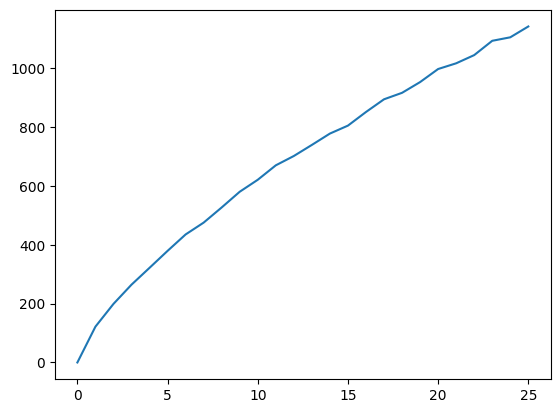

In [ ]:
import matplotlib.pyplot as plt
plt.plot(regrets_ReUCB[0])
plt.show()



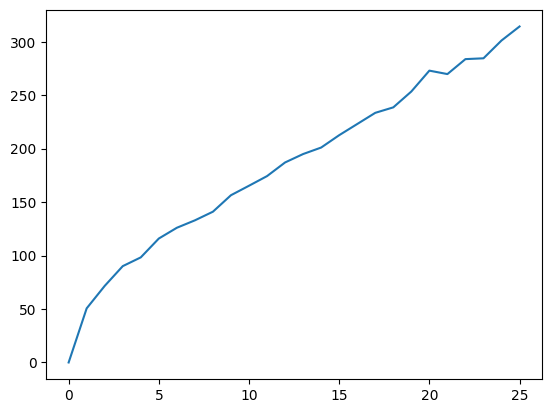

In [ ]:
plt.plot(regrets_ReUCB[1])
plt.show()

For suburban_L-Band with Number of arms = 4, K = 2

In [ ]:
actions = init_actions("C:\\Users\\aarya\\Downloads\\SURGE\\Suburban_L-band.txt")  # Read the instance file
best_upper_bound = best_average(actions)  # An upper bound for the average reward of the optimal policy
best_oracle = game_whittle(actions, 10000000, 2) / 10000000  # An average of the offline oracle

The game is in timestep 200
The game is in timestep 400
The game is in timestep 600
The game is in timestep 800
The game is in timestep 1000
The game is in timestep 1200
The game is in timestep 1400
The game is in timestep 1600
The game is in timestep 1800
The game is in timestep 2000
The game is in timestep 2200
The game is in timestep 2400
The game is in timestep 2600
The game is in timestep 2800
The game is in timestep 3000
The game is in timestep 3200
The game is in timestep 3400
The game is in timestep 3600
The game is in timestep 3800
The game is in timestep 4000
The game is in timestep 4200
The game is in timestep 4400
The game is in timestep 4600
The game is in timestep 4800
The game is in timestep 5000
The game is in timestep 5200
The game is in timestep 5400
The game is in timestep 5600
The game is in timestep 5800
The game is in timestep 6000
The game is in timestep 6200
The game is in timestep 6400
The game is in timestep 6600
The game is in timestep 6800
The game is in tim

In [ ]:
regrets_ReUCB = regret_reucb(actions, 5000, 1000, best_oracle, 2)  # The Restless-UCB policy with T = 5000 to 50000 and 1000 runs
print("The Average Regret:")
print_vector(regrets_ReUCB[0])  # The average regrets
print("The variances:")
print_vector(regrets_ReUCB[1])  # The variance of regrets

1624.7919999999986 is the sum regret in the iteration 0
2940.8520000000017 is the sum regret in the iteration 1
4183.900999999996 is the sum regret in the iteration 2
5394.352999999997 is the sum regret in the iteration 3
6567.613 is the sum regret in the iteration 4
7733.785000000004 is the sum regret in the iteration 5
8864.050000000007 is the sum regret in the iteration 6
9996.490999999998 is the sum regret in the iteration 7
11112.568999999996 is the sum regret in the iteration 8
12224.865999999996 is the sum regret in the iteration 9
13316.438999999975 is the sum regret in the iteration 10
14416.416000000003 is the sum regret in the iteration 11
15509.796000000024 is the sum regret in the iteration 12
16594.256999999994 is the sum regret in the iteration 13
17675.17599999998 is the sum regret in the iteration 14
18760.692000000006 is the sum regret in the iteration 15
19827.270999999993 is the sum regret in the iteration 16
20898.88699999998 is the sum regret in the iteration 17
2

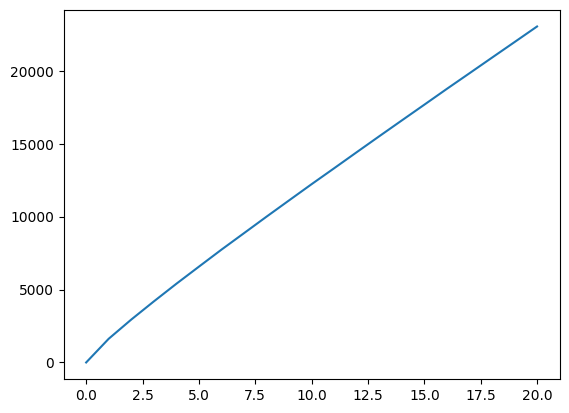

0.839574


In [163]:
plt.plot(regrets_ReUCB[0])
plt.show()
print(best_oracle)

In [181]:
regret = []
regrets = regrets_ReUCB[0]
for i in range(len(regrets_TS4[0])):
    regret.append(regrets[i])

In [203]:
regrets_TS9 = regret_ts_vector(actions, 5000, 9, 1000, best_oracle, 2)  # The TS policy with T = 5000 to 50000 and 1000 runs, its support on transition matrices are [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]^2
print_vector(regrets_TS9[0])  # The average regrets
print_vector(regrets_TS9[1])  # The variance of regrets

regrets_TS4 = regret_ts_vector(actions, 5000, 4, 1000, best_oracle, 2)  # The TS policy with T = 5000 to 50000 and 1000 runs, its support on transition matrices are [0.2, 0.4, 0.6, 0.8]^2
print_vector(regrets_TS4[0])  # The average regrets
print_vector(regrets_TS4[1])  # The variance of regrets


[0.0, 2373.0, 4676.0, 7031.0, 9361.0, 11755.0, 14032.0, 16429.0, 18723.0, 21078.0, 23497.0] in game number 0
[0.0, 2305.0, 4547.0, 6769.0, 8932.0, 11150.0, 13404.0, 15601.0, 17864.0, 20023.0, 22194.0] in game number 100
[0.0, 2055.0, 4088.0, 6176.0, 8260.0, 10273.0, 12327.0, 14439.0, 16453.0, 18504.0, 20578.0] in game number 200
[0.0, 2168.0, 4390.0, 6611.0, 8741.0, 11000.0, 13220.0, 15427.0, 17666.0, 19892.0, 22167.0] in game number 300
[0.0, 2253.0, 4492.0, 6735.0, 9002.0, 11246.0, 13480.0, 15721.0, 17934.0, 20156.0, 22372.0] in game number 400
[0.0, 2476.0, 4883.0, 7306.0, 9766.0, 12265.0, 14702.0, 17144.0, 19591.0, 21904.0, 24282.0] in game number 500
[0.0, 2248.0, 4490.0, 6718.0, 8958.0, 11106.0, 13275.0, 15428.0, 17637.0, 19780.0, 22043.0] in game number 600
[0.0, 2200.0, 4456.0, 6666.0, 8847.0, 11053.0, 13245.0, 15493.0, 17665.0, 19919.0, 22120.0] in game number 700
[0.0, 2136.0, 4349.0, 6543.0, 8751.0, 10869.0, 13083.0, 15256.0, 17391.0, 19500.0, 21650.0] in game number 800
[0.

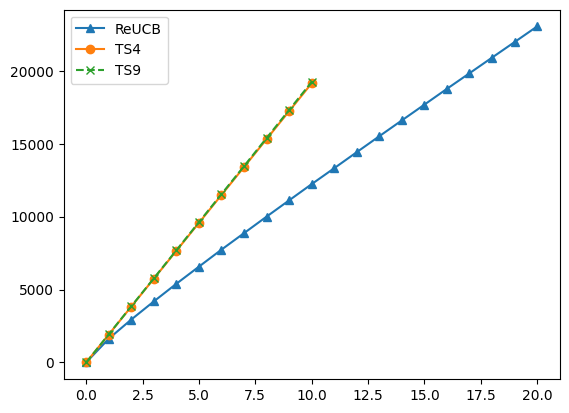

In [216]:

plt.plot(regrets_ReUCB[0], label = 'ReUCB', marker = '^')
plt.plot(regrets_TS4[0], label = 'TS4', marker = 'o')
plt.plot(regrets_TS9[0], label = 'TS9', marker = 'x', linestyle = '--' )
plt.legend()
plt.show()


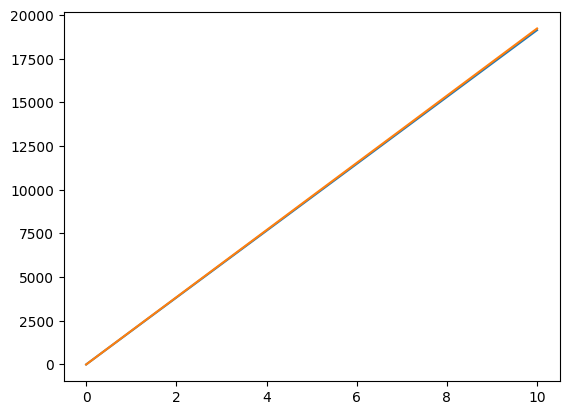

In [211]:
plt.plot(regrets_TS4[0])
plt.plot(regrets_TS9[0])
plt.show()

In [205]:
print(len(regret))
print(len(regrets_TS4[0]))
print(len(regrets_TS9[0]))

11
11
11


In [188]:
print(regret)
print(regrets_TS4)
print(regrets_TS9)

[0.0, 1624.7919999999986, 2940.8520000000017, 4183.900999999996, 5394.352999999997, 6567.613, 7733.785000000004, 8864.050000000007, 9996.490999999998, 11112.568999999996, 12224.865999999996]
[[0.0, 1926.7420000000034, 3850.265000000003, 5774.479999999996, 7696.452999999999, 9625.588000000009, 11550.106999999995, 13474.847000000016, 15400.69499999997, 17322.955999999995, 19245.328000000005], [0.0, 146.1967633567405, 286.85440797550564, 425.27140639837444, 564.9490032480826, 703.3728395067413, 843.4575331522067, 981.529002093635, 1120.9165155245046, 1260.5185957077294, 1400.565657017105]]
[[0.0, 1920.8649999999986, 3840.7110000000016, 5761.877000000005, 7680.132999999998, 9599.048999999999, 11517.039000000015, 13435.733999999986, 15357.117, 17275.090000000004, 19195.113000000005], [0.0, 142.43483764513692, 276.4420774031891, 410.8604163349929, 546.7853350182813, 683.2382720536502, 821.0429052361874, 952.5780971994665, 1088.1278823515554, 1222.4733258439921, 1356.5408185642352]]


In [217]:
def game_ucrl2_cascading(actions, T, k=2):
    """
    UCRL2 algorithm with cascading and sensing up to k arms.
    Assuming k=2 for this implementation.
    """
    ob = init_observation(actions)
    t = 0
    reward = 0.0
    rewards = [0.0]

    delta = 0.001
    TMAX = 10

    n = len(actions)
    m = actions[0].m

    # Initialize non-transition observations
    non_trans_observation = [[[[0 for _ in range(m)] for _ in range(TMAX)]
                             for _ in range(m)] for _ in range(n)]

    t_k = 0

    while t < 10 * T:
        stop = False
        all_states = available_states(actions, TMAX - 1) # Need to adapt available_states for cascading states
        non_trans_observation2 = [[[row[:] for row in matrix] for matrix in tensor]
                                 for tensor in non_trans_observation]
        gap = 10000.0

        u = len(all_states)
        v = len(all_states[0]) if u > 0 else 0
        w = len(all_states[0][0]) if v > 0 else 0
        t_k = max(1, t) # Ensure t_k is at least 1 to avoid log(0)

        # Value iteration
        iter_count = 0
        while gap > 0.001 and iter_count <= 100:
            all_states2 = [[row[:] for row in matrix] for matrix in all_states]
            max_val = -10000.0
            min_val = 10000.0

            for l in range(u):
                for i in range(v):
                    for tt in range(w):
                        V = -10000.0
                        # Need to adapt state and time indexing for cascading states
                        state_1 = all_states[l][i][tt].states[0] if all_states[l][i][tt].states else 0
                        state_2 = all_states[l][i][tt].states[1] if len(all_states[l][i][tt].states) > 1 else 0
                        time_1 = all_states[l][i][tt].times[0] - 1 if all_states[l][i][tt].times else 0
                        time_2 = all_states[l][i][tt].times[1] - 1 if len(all_states[l][i][tt].times) > 1 else 0


                        for k_arm in range(k): # Iterate over the k arms that can be sensed
                            sum_val = 0.0
                            V_values = [0.0] * m # Value for each possible next state

                            for next_st in range(m):
                                # Need to adapt next state indexing for cascading states
                                if (l < len(all_states[l][i][tt].Next_stat) and
                                    k_arm < len(all_states[l][i][tt].Next_stat) and # Check arm index
                                    next_st < len(all_states[l][i][tt].Next_stat[k_arm])): # Check next state index
                                    V_values[next_st] = all_states[l][i][tt].Next_stat[k_arm][next_st].V_value + actions[k_arm].r[next_st]
                                else:
                                    # Handle cases where Next_stat is not properly populated
                                    V_values[next_st] = actions[k_arm].r[next_st] # Use immediate reward as a fallback

                            # Need to adapt non_trans_observation indexing for cascading states
                            if k_arm == 0:
                                numbers = non_trans_observation[0][state_1][time_1]
                            else: # Assuming k=2, so only two arms to consider
                                numbers = non_trans_observation[1][state_2][time_2]

                            number = sum(numbers)

                            if number == 0:
                                sum_val = maxin(V_values)
                            else:
                                maximum_idx = maxindex(V_values)
                                minimum_idx = minindex(V_values)

                                max_p = numbers[maximum_idx] / number
                                min_p = numbers[minimum_idx] / number
                                rad = math.sqrt(56 * 2 * math.log(4 * t_k / delta) / (2 * number))

                                # Need to use the correct probability for the chosen arm
                                prob_dist = [num / number for num in numbers]

                                # UCRL2 confidence interval calculation
                                # The confidence interval is on the transition probabilities
                                # We need to find the best and worst case next state values based on the confidence interval
                                # This is a simplification, the full UCRL2 with cascading would require a more complex optimization
                                # within the value iteration to find the optimistic transition probabilities.
                                # For this implementation, we will use a simplified approach by considering the confidence interval
                                # around the observed probabilities.

                                optimistic_sum_val = 0.0
                                pessimistic_sum_val = 0.0

                                for next_st in range(m):
                                    lower_bound = max(0.0, prob_dist[next_st] - rad)
                                    upper_bound = min(1.0, prob_dist[next_st] + rad)

                                    # This is a simplification, the true optimistic/pessimistic probability calculation
                                    # involves considering the sum of probabilities being 1 and the correlation between them.
                                    # For this example, we'll just use the bounds on individual probabilities.
                                    optimistic_sum_val += upper_bound * V_values[next_st]
                                    pessimistic_sum_val += lower_bound * V_values[next_st]

                                # In UCRL2, we choose the action that maximizes the value function under the optimistic transition probabilities.
                                sum_val = optimistic_sum_val # Using optimistic value


                            if sum_val > V:
                                # Need to store the chosen arm for the current state based on the cascading policy
                                # This assumes a policy that selects one of the k arms to sense
                                # and then potentially pulls another arm based on the observation.
                                # For this simplified implementation, we'll just store the sensed arm.
                                all_states[l][i][tt].action = k_arm
                                V = sum_val

                        all_states2[l][i][tt].V_value = V

            # Update V values and compute gap
            for l in range(u):
                for i in range(v):
                    for tt in range(w):
                        V_prime = all_states[l][i][tt].V_value
                        V = all_states2[l][i][tt].V_value
                        all_states[l][i][tt].V_value = V
                        gap2 = V_prime - V
                        max_val = max(max_val, gap2)
                        min_val = min(min_val, gap2)

            gap = max_val - min_val
            iter_count += 1

        # Execute policy based on the computed value function and cascading sensing
        while not stop and t < 10 * T:
            # Need to determine the current state index based on the cascading state representation
            # This will depend on how available_states is adapted.
            # For this simplified example, we'll use the original state indexing logic,
            # which might not be fully correct for a cascading state space.
            if ob.t[0] == 1:
                l = ob.s[0]
                sprime = ob.s[1]
                timeprime = ob.t[1] - 2
            else:
                l = 2 + ob.s[1]
                sprime = ob.s[0]
                timeprime = ob.t[0] - 2

            timeprime = min(timeprime, TMAX - 2)

            # Need to get the action from the precomputed policy based on the current state
            # The action here should correspond to which arm to sense in the cascading setting
            # and potentially which arm to pull after sensing.
            # For this simplified implementation, we'll assume the action is the index of the arm to sense.
            if l < len(all_states) and sprime < len(all_states[l]) and timeprime < len(all_states[l][sprime]):
                 actions_state = all_states[l][sprime][timeprime]
                 arm_to_sense = actions_state.action # This is the arm chosen to sense
            else:
                 arm_to_sense = 0 # Default to sensing the first arm if state not found


            # In a cascading setting, after sensing one or more arms, a decision is made
            # on which arm to pull. This logic needs to be implemented here.
            # For this simplified implementation, we will just pull the sensed arm.
            arm_to_pull = arm_to_sense


            start_state = ob.s[arm_to_pull]
            running_time = min(ob.t[arm_to_pull] - 1, TMAX - 1)

            ob = update2(ob, arm_to_pull, actions) # Update observation based on the pulled arm
            end_state = ob.s[arm_to_pull]
            reward += bernoulli(actions[arm_to_pull].r[ob.s[arm_to_pull]])
            t += 1

            if t % T == 0:
                rewards.append(reward)

            # Update non_trans_observation for the pulled arm
            if (arm_to_pull < len(non_trans_observation) and
                start_state < len(non_trans_observation[arm_to_pull]) and
                running_time < len(non_trans_observation[arm_to_pull][start_state]) and
                end_state < len(non_trans_observation[arm_to_pull][start_state][running_time])):
                non_trans_observation[arm_to_pull][start_state][running_time][end_state] += 1

            # Check stopping condition based on observations for the *sensed* arms
            # This stopping condition logic needs to be adapted for cascading sensing
            # It should likely check if enough observations have been collected for the *sensed* arms
            # to reduce the confidence interval sufficiently.
            # For this simplified implementation, we'll use the stopping condition based on the *pulled* arm,
            # which is not fully correct for cascading.
            if (arm_to_pull < len(non_trans_observation) and
                start_state < len(non_trans_observation[arm_to_pull]) and
                running_time < len(non_trans_observation[arm_to_pull][start_state])):
                u_count = sumover(non_trans_observation[arm_to_pull][start_state][running_time])
                v_count = sumover(non_trans_observation2[arm_to_pull][start_state][running_time])

                if u_count > v_count * 2:
                    stop = True

        t_k = t

    return rewards

# Note: The `available_states` function needs to be adapted to represent the state space
# for the cascading setting. The current `available_states` implementation seems
# specific to a non-cascading setting with two arms.

# The `init`, `update2`, `maxin`, `maxindex`, `minindex`, `minin`, and `sumover`
# functions are assumed to be defined elsewhere in the notebook and are used here.
# The `matrix_power` and `next_distribution` functions are also assumed to be available.

UCRL2 Regret

In [218]:
def regret_ucrl2_cascading(actions: List[Action], T: int, number: int, best: float, k: int = 2) -> List[List[float]]:
    """
    Calculate regret for UCRL2 algorithm with cascading and sensing (vector version).

    Args:
        actions: List of Action objects.
        T: Time horizon for each segment of regret calculation (e.g., 5000). The total time will be 10*T.
        number: Number of simulation runs.
        best: Average reward of the optimal policy (best oracle).
        k: Number of arms to sense in the cascading setting.

    Returns:
        A list containing two lists: average regrets and variance of regrets over time.
    """
    regrets = [0.0] * 11
    variance = [0.0] * 11

    for j in range(number):
        # game_ucrl2_cascading should return cumulative rewards at intervals of T
        rewards = game_ucrl2_cascading(actions, T, k)
        if j%100 == 0:
          print(f"{rewards} for UCRL2 in game {j}")
        for i in range(len(rewards)): # Iterate up to the number of reward points returned
            regrets[i] += (best * T * i - rewards[i]) / number
            variance[i] += (best * T * i - rewards[i]) ** 2 / number

    for i in range(len(regrets)):
        # Avoid calculating sqrt of negative numbers due to potential floating point issues
        variance[i] = math.sqrt(max(0, variance[i] - regrets[i] ** 2))

    return [regrets, variance]

In [219]:
random.seed(int(time.time()))

regrets_UCRL = regret_ucrl2_cascading(actions, 5000, 1000, best_oracle)  # The Colored-UCRL policy with T = 5000 to 50000 and 1000 runs
print_vector(regrets_UCRL[0])  # The average regrets
print_vector(regrets_UCRL[1])  # The variance of regrets


[0.0, 2102.0, 4201.0, 6310.0, 8400.0, 10540.0, 12635.0, 14763.0, 16908.0, 19036.0, 21151.0] for UCRL2 in game 0
[0.0, 2049.0, 4154.0, 6278.0, 8428.0, 10564.0, 12728.0, 14871.0, 16899.0, 19068.0, 21163.0] for UCRL2 in game 100
[0.0, 2069.0, 4128.0, 6307.0, 8488.0, 10598.0, 12762.0, 14898.0, 17046.0, 19070.0, 21261.0] for UCRL2 in game 200
[0.0, 2073.0, 4129.0, 6264.0, 8308.0, 10316.0, 12387.0, 14521.0, 16683.0, 18745.0, 20882.0] for UCRL2 in game 300
[0.0, 1945.0, 4031.0, 6143.0, 8268.0, 10397.0, 12463.0, 14596.0, 16678.0, 18817.0, 20863.0] for UCRL2 in game 400
[0.0, 2103.0, 4158.0, 6296.0, 8410.0, 10521.0, 12584.0, 14631.0, 16761.0, 18820.0, 20951.0] for UCRL2 in game 500
[0.0, 2024.0, 4116.0, 6297.0, 8411.0, 10514.0, 12676.0, 14748.0, 16795.0, 18871.0, 20960.0] for UCRL2 in game 600
[0.0, 2038.0, 4171.0, 6238.0, 8329.0, 10541.0, 12627.0, 14697.0, 16816.0, 18903.0, 21019.0] for UCRL2 in game 700
[0.0, 2091.0, 4193.0, 6221.0, 8379.0, 10465.0, 12459.0, 14580.0, 16693.0, 18779.0, 20827.0

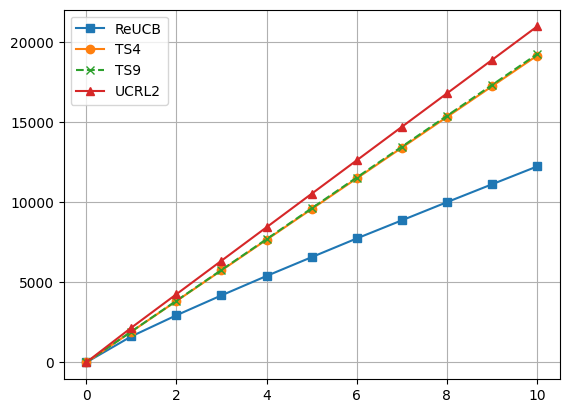

In [222]:
plt.plot(regret, label = 'ReUCB', marker = 's')
plt.plot(regrets_TS4[0], label = 'TS4', marker = 'o')
plt.plot(regrets_TS9[0], label = 'TS9', marker = 'x', linestyle = '--' )
plt.plot(regrets_UCRL[0], label = 'UCRL2', marker = '^')
plt.legend()
plt.grid(True)

plt.show()

For URBAN L- Band, number of arms = 4, k = 2

In [227]:
random.seed(int(time.time()))
actions_urban = init_actions("C:\\Users\\aarya\\Downloads\\SURGE\\Urban_L-band.txt")  # Read the instance file
best_upper_bound_urban = best_average(actions)  # An upper bound for the average reward of the optimal policy
best_oracle_urban = game_whittle(actions, 10000000, 2) / 10000000  # An average of the offline oracle
print(best_oracle_urban)

The game is in timestep 200
The game is in timestep 400
The game is in timestep 600
The game is in timestep 800
The game is in timestep 1000
The game is in timestep 1200
The game is in timestep 1400
The game is in timestep 1600
The game is in timestep 1800
The game is in timestep 2000
The game is in timestep 2200
The game is in timestep 2400
The game is in timestep 2600
The game is in timestep 2800
The game is in timestep 3000
The game is in timestep 3200
The game is in timestep 3400
The game is in timestep 3600
The game is in timestep 3800
The game is in timestep 4000
The game is in timestep 4200
The game is in timestep 4400
The game is in timestep 4600
The game is in timestep 4800
The game is in timestep 5000
The game is in timestep 5200
The game is in timestep 5400
The game is in timestep 5600
The game is in timestep 5800
The game is in timestep 6000
The game is in timestep 6200
The game is in timestep 6400
The game is in timestep 6600
The game is in timestep 6800
The game is in tim

In [ ]:
random.seed(int(time.time()))

regrets_TS9_urban = regret_ts_vector(actions_urban, 5000, 9, 1000, best_oracle_urban, 2)  # The TS policy with T = 5000 to 50000 and 1000 runs, its support on transition matrices are [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]^2
print_vector(regrets_TS9_urban[0])  # The average regrets
print_vector(regrets_TS9_urban[1])  # The variance of regrets

regrets_TS4_urban = regret_ts_vector(actions_urban, 5000, 4, 1000, best_oracle_urban, 2)  # The TS policy with T = 5000 to 50000 and 1000 runs, its support on transition matrices are [0.2, 0.4, 0.6, 0.8]^2
print_vector(regrets_TS4_urban[0])  # The average regrets
print_vector(regrets_TS4_urban[1])  # The variance of regrets


[0.0, 3342.0, 6801.0, 10202.0, 13711.0, 17188.0, 20598.0, 23936.0, 27407.0, 30860.0, 34279.0] in game number 0
[0.0, 3529.0, 7123.0, 10636.0, 14206.0, 17660.0, 21166.0, 24646.0, 28134.0, 31621.0, 35163.0] in game number 100
[0.0, 3533.0, 7044.0, 10583.0, 14141.0, 17706.0, 21318.0, 24900.0, 28432.0, 31996.0, 35540.0] in game number 200
[0.0, 3473.0, 6652.0, 9917.0, 13229.0, 16497.0, 19883.0, 23149.0, 26404.0, 29686.0, 32971.0] in game number 300
[0.0, 3775.0, 7514.0, 11220.0, 15019.0, 18693.0, 22530.0, 26282.0, 30048.0, 33844.0, 37662.0] in game number 400
[0.0, 3313.0, 6509.0, 9797.0, 13180.0, 16439.0, 19659.0, 22828.0, 26050.0, 29358.0, 32612.0] in game number 500
[0.0, 3473.0, 6944.0, 10487.0, 14015.0, 17521.0, 21015.0, 24551.0, 28052.0, 31562.0, 34987.0] in game number 600
[0.0, 3753.0, 7402.0, 10980.0, 14632.0, 18342.0, 21953.0, 25585.0, 29201.0, 32823.0, 36560.0] in game number 700
[0.0, 3207.0, 6638.0, 10017.0, 13347.0, 16723.0, 20129.0, 23551.0, 26912.0, 30277.0, 33750.0] in gam

TypeError: regret_reucb() missing 1 required positional argument: 'k'

In [229]:
print_vector(regrets_TS4_urban)

[0.0, 3964.3789999999995, 7928.5310000000145, 11892.905000000004, 15855.253999999999, 19816.811000000016, 23780.489000000012, 27744.30200000005, 31704.018, 35669.088, 39632.28999999997]
[0.0, 215.43119086152998, 422.8692465038863, 630.5765340989487, 836.0724771814647, 1045.7308512056097, 1253.8918724478824, 1458.5914691142232, 1666.5307531214617, 1872.8485391828049, 2080.6276994223026]



In [230]:
regrets_ReUCB_urban = regret_reucb(actions_urban, 5000, 1000, best_oracle_urban, 2)  # The Restless-UCB policy with T = 5000 to 50000 and 1000 runs
print("The Average Regret:")
print_vector(regrets_ReUCB_urban[0])  # The average regrets
print("The variances:")
print_vector(regrets_ReUCB_urban[1])  # The variance of regrets

regrets_UCRL_urban = regret_ucrl2_cascading(actions_urban, 5000, 1000, best_oracle_urban, 2)  # The Colored-UCRL policy with T = 5000 to 50000 and 1000 runs
print_vector(regrets_UCRL_urban[0])  # The average regrets
print_vector(regrets_UCRL_urban[1])  # The variance of regrets


3938.9480000000003 is the sum regret in the iteration 0
7375.397000000006 is the sum regret in the iteration 1
10735.137999999994 is the sum regret in the iteration 2
14017.929000000011 is the sum regret in the iteration 3
17251.692 is the sum regret in the iteration 4
20475.452000000012 is the sum regret in the iteration 5
23661.639999999992 is the sum regret in the iteration 6
26847.041000000034 is the sum regret in the iteration 7
29981.815000000017 is the sum regret in the iteration 8
33119.941 is the sum regret in the iteration 9
36266.25900000005 is the sum regret in the iteration 10
39395.36900000004 is the sum regret in the iteration 11
42496.63299999999 is the sum regret in the iteration 12
45584.466999999975 is the sum regret in the iteration 13
48697.74900000002 is the sum regret in the iteration 14
51774.012000000075 is the sum regret in the iteration 15
54913.20199999999 is the sum regret in the iteration 16
57938.22100000007 is the sum regret in the iteration 17
61039.199

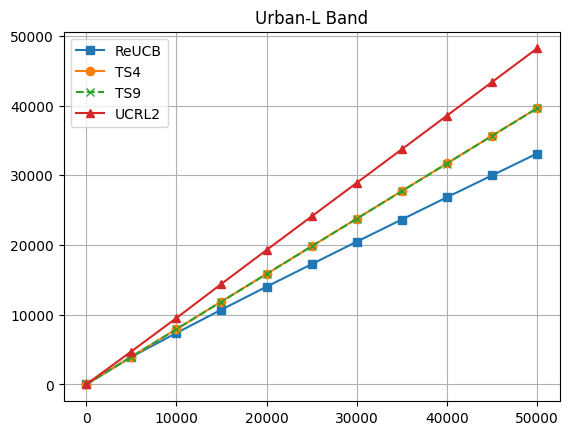

In [243]:
regrets_urban = []
regrets = regrets_ReUCB_urban[0]
for i in range(len(regrets_TS4_urban[0])):
    regrets_urban.append(regrets[i])
    
x = []
for i in range(11):
    x.append(i*5000)
plt.plot(x,regrets_urban, label = 'ReUCB', marker = 's')
plt.plot(x,regrets_TS4_urban[0], label = 'TS4', marker = 'o')
plt.plot(x,regrets_TS9_urban[0], label = 'TS9', marker = 'x', linestyle = '--' )
plt.plot(x,regrets_UCRL_urban[0], label = 'UCRL2', marker = '^')
plt.legend()
plt.title("Urban-L Band")
plt.grid(True)

plt.show()

In [237]:
print(regrets_urban)

[0.0, 3938.9480000000003]
